# Data Correlation

In this section, we analyze and visualize the relationships between the independent variables and the target variable. By examining correlations, we aim to identify how strongly each feature influences the target variable, gaining insights into the feature selection process for modelling.

In [1]:
# import requiered libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read raw train data
train = pd.read_csv( '../../../data/raw/train.csv' , index_col = 0 )
train.head()

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


In [3]:
# Read the 'all_train.csv' file, to get a table of time resolution
all_train = pd.read_csv( '../../../data/interim/all_train.csv' ,  parse_dates = [0] ,  index_col = 0 )
display( all_train.head() )

time_res = all_train[['p_num','initial_resolution']].drop_duplicates()
time_res_d = dict( zip( time_res.p_num , time_res.initial_resolution ) )
# pprint( time_res_d )

#Add the time resolution to the raw data
train['initial_resolution'] = train['p_num'].map( time_res_d )

# NOTE: some entries in activity are really the same category. For example 'Walk' & 'Walking'
# Here, we convert those cases to the same category
conv_d = {
    'Walking':'Walk',
    'Running':'Run',
    'Weights':'Strength training'

}

all_train['activity'] = all_train['activity'].replace( conv_d )

,p_num,days_since_start,time,initial_resolution,bg,insulin,carbs,hr,steps,cals,activity,bg+1:00
2020-01-01 00:15:00,p01,0,00:15:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:20:00,p01,0,00:20:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:25:00,p01,0,00:25:00,15min,9.6,0.0083,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:30:00,p01,0,00:30:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:35:00,p01,0,00:35:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN


## Global Correlations Between Lag Features and Target Variable

To understand the relationships between the lag features and the target variable, we compute and visualize their correlations within the raw dataset. The heatmap below highlights these global correlations, providing insights into how features interact and influence the target variable.

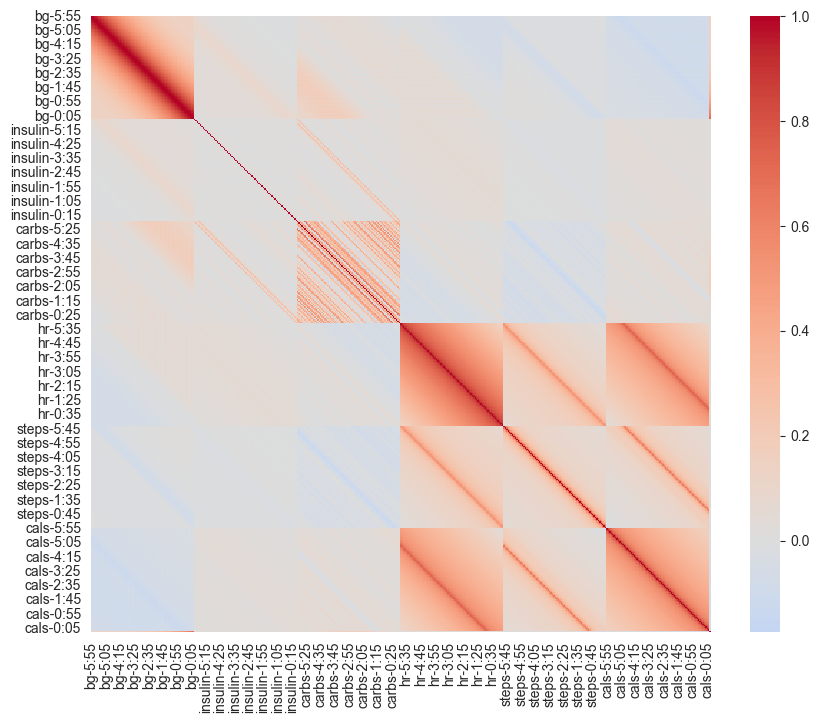

In [4]:
plt.figure( figsize=(10,8) )
corr_df = train.select_dtypes( include = np.number ).corr()
sns.heatmap( corr_df , center = 0 , cmap = "coolwarm" );

### Observations from the Heatmap

The heatmap highlights the temporal consistency within each variable and weaker inter-variable relationships. Strong self-correlations across time lags indicate temporal consistency in the data, where previous values closely predict subsequent ones. The weak or moderate correlations between different features suggest more complex, indirect dependencies that may require advanced modelling to predict effectively.

## Highlight of the Correlation of the Target Variable Against All Features

To focus specifically on how ``bg+1:00`` correlates with all other features in the raw dataset, we visualize its correlations in the heatmap below. This helps identify which features have the strongest influence on predicting future blood glucose levels.

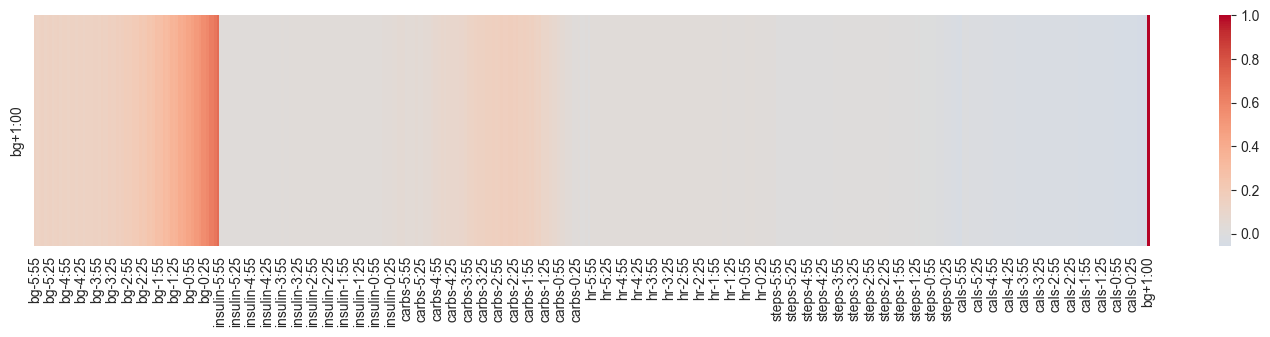

In [5]:
plt.figure( figsize=(18,3) )
sns.heatmap( pd.DataFrame( corr_df.loc[:,'bg+1:00'] ).T , center = 0 , cmap = "coolwarm" );

The heatmap highlights that ``bg+1:00`` is most strongly correlated with recent lagged bg values, reflecting the temporal dependency of blood glucose levels. Moderate correlations are observed with features like insulin and carbs, while activity-related features (steps, hr, cals) show weaker correlations, indicating their more indirect impact on future blood glucose. 

## Cumulative Distribution of Lag Feature Correlations to ``bg+1:00``

To analyze how strongly different lagged features correlate with the target variable ``bg+1:00``, we calculate the Pearson correlation coefficients and plot their cumulative distribution function (ECDF). This visualization highlights the distribution of correlation strengths across all lagged features.

1. Correlation Extraction:
    * Pearson correlation coefficients for all lagged features with ``bg+1:00`` are computed and grouped by feature type (e.g., ``bg``, ``insulin``, ``carbs``, etc.).
    * The average correlation for each feature type is calculated.
2. ECDF Plot:
    * The ECDF shows the cumulative proportion of features that achieve a given level of correlation with ``bg+1:00``.

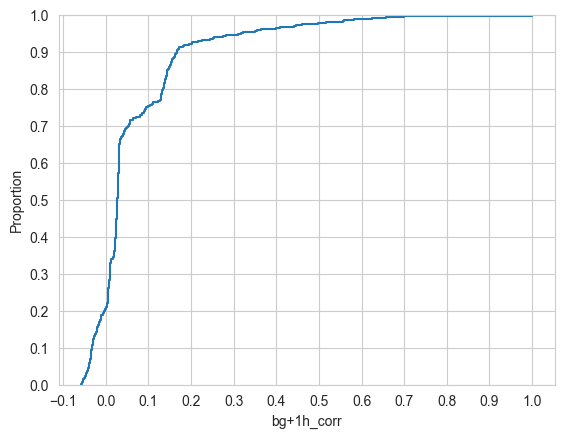

In [6]:
# Extract the pearson r coefficients
bg_plus_1_corr = pd.DataFrame( corr_df.loc[:,'bg+1:00'] ).sort_values( 'bg+1:00' , ascending = False ).reset_index()
bg_plus_1_corr.columns = ['column','bg+1h_corr']
bg_plus_1_corr[['metric','time']] = bg_plus_1_corr['column'].str.split('-',expand=True)
bg_plus_1_corr.groupby('metric').agg({'bg+1h_corr':np.mean})

# Plot the ECDF
sns.ecdfplot(data=bg_plus_1_corr, x="bg+1h_corr")
plt.xticks( np.arange(-0.1,1.01,.1) )
plt.yticks( np.arange(0,1.01,.1) );

### Observations
The ECDF shows that lagged ``bg`` features have the strongest correlations with ``bg+1:00``, dominating the higher correlation range. In contrast, features like insulin, carbs, steps, hr, and cals exhibit weaker correlations, contributing less to the prediction of future glucose levels.

## Examples of High-, Mid- and Low-Correlataed Features with ``bg+1:00``
To demonstrate the relationship between features and the target variable ``bg+1:00``, we visualize the density of data points and overlay a regression line (red) of least squares.

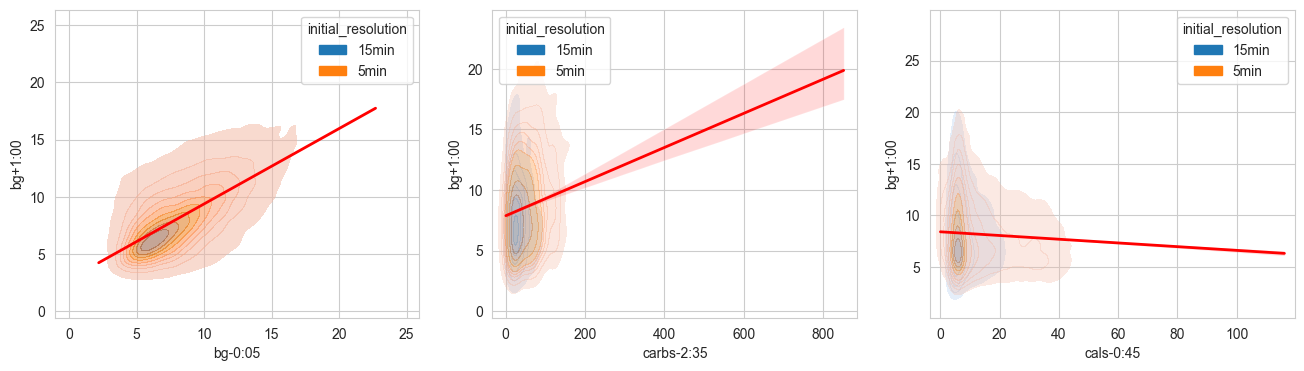

In [7]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax = ax.flatten()

sns.kdeplot( data = train , y = 'bg+1:00' , x = 'bg-0:05' , hue = 'initial_resolution' , fill = True , alpha = .5, ax = ax[0] )
sns.regplot( data = train , y = 'bg+1:00' , x = 'bg-0:05' , scatter = False , color = 'red' , line_kws={'linewidth': 2} , ax = ax[0] )

sns.kdeplot( data = train , y = 'bg+1:00' , x = 'carbs-2:35' , hue = 'initial_resolution' , fill = True , alpha = .3 , ax = ax[1] )
sns.regplot( data = train , y = 'bg+1:00' , x = 'carbs-2:35' , scatter = False , color = 'red' , line_kws={'linewidth': 2} , ax = ax[1] )

sns.kdeplot( data = train , y = 'bg+1:00' , x = 'cals-0:45' , hue = 'initial_resolution' , fill = True , alpha = .3 , ax = ax[2] )
sns.regplot( data = train , y = 'bg+1:00' , x = 'cals-0:45' , scatter = False , color = 'red' , line_kws={'linewidth': 2} , ax = ax[2] );

### Observations
1. High-correlated feature (``bg-0:05``):
    * The plot shows a strong positive linear relationship with the target variable, as indicated by the clear density alignment along the regression line. This highlights the predictive importance of recent blood glucose levels.
2. Mid-correlated feature (``carbs-2:35``):
    * The plot shows a moderate relationship to ``bg+1:00``, with some density clustering but less alignment along the regression line compared to ``bg-0:05``. This suggests a weaker but still relevant influence of carbohydrate intake on future blood glucose levels.
3. Low-correlated feature (``cals-0:45``):
    * The plot exhibits a minimal relationship to ``bg+1:00``, with widely dispersed density and poor alignment with the regression line. This indicates that calorie expenditure has little direct influence on predicting future blood glucose levels.

These examples emphasize the varying degrees of feature relevance, with ``bg`` lag features being the most predictive and activity-related features contributing less.

## Correlation Between All Numeric Variables as a Time Series

This visualization shows the correlation between all numeric variables (bg, insulin, carbs, hr, steps, cals, and bg+1:00) using a clustered heatmap. By organizing features based on their correlation patterns, this plot highlights relationships and clusters of interdependent variables.

<Figure size 300x300 with 0 Axes>

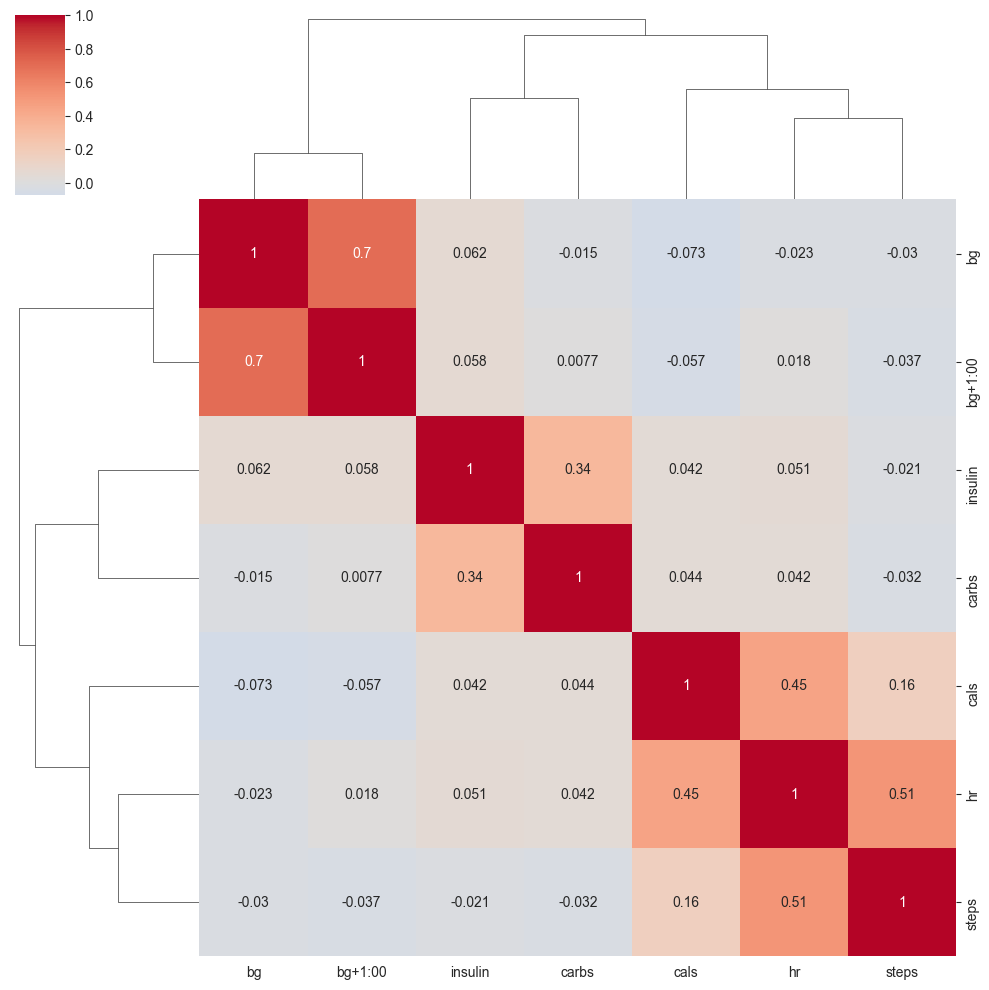

In [8]:
plt.figure( figsize=(3,3) )
sns.clustermap( 
    all_train[['bg','insulin','carbs','hr','steps','cals','bg+1:00']].corr() , 
    center = 0 , 
    cmap = "coolwarm" , 
    annot = True 
    );

### Conclusion
This clustered heatmap reveals once again clear groupings of variables, emphasizing the dominant role of lagged ``bg`` and related features in predicting future glucose levels, while activity metrics show weaker relevance.

## Summary
* Lagged ``bg``-features exhibit the strongest correlation with ``bg+1:00``, underscoring the temporal dependency of blood glucose levels.
* Features such as ``carbs`` and ``insulin`` show moderate correlations with ``bg+1:00``, reflecting their role in glucose regulation.
* Activity-related metrics (``steps``, ``cals``, ``hr``) have weak correlations with ``bg+1:00``, indicating their indirect or limited impact on predicting future glucose levels.
* A notable correlation exists between ``carbs`` and ``insulin``, highlighting their relationship in dietary management.